In [ ]:
!pip install timm
!pip install torchvision
!pip install wandb
import zipfile
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
from tqdm import tqdm
import wandb
!unzip /content/cats-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats/cats/5499.jpg      
  inflating: cats/cats/55.jpg        
  inflating: cats/cats/550.jpg       
  inflating: cats/cats/5500.jpg      
  inflating: cats/cats/5501.jpg      
  inflating: cats/cats/5502.jpg      
  inflating: cats/cats/5503.jpg      
  inflating: cats/cats/5504.jpg      
  inflating: cats/cats/5505.jpg      
  inflating: cats/cats/5506.jpg      
  inflating: cats/cats/5507.jpg      
  inflating: cats/cats/5508.jpg      
  inflating: cats/cats/5509.jpg      
  inflating: cats/cats/551.jpg       
  inflating: cats/cats/5510.jpg      
  inflating: cats/cats/5511.jpg      
  inflating: cats/cats/5512.jpg      
  inflating: cats/cats/5513.jpg      
  inflating: cats/cats/5514.jpg      
  inflating: cats/cats/5515.jpg      
  inflating: cats/cats/5516.jpg      
  inflating: cats/cats/5517.jpg      
  inflating: cats/cats/5518.jpg      
  inflating: cats/cats/5519.jpg      
  inflating: cats/cats/552.jpg       

In [ ]:

import torch.nn.functional as F

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_SAMPLES = 12
RUN_NAME = 'gan_avariation'
SEED = 0
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
BETA1 = 0.5
BETA2 = 0.999
LATENT_DIMS = 100
NUM_GEN_KERN = 128
NUM_DISC_KERN = 128
NUM_CHANNELS = 3
EPOCHS = 20

In [ ]:
def prepare_data(BATCH_SIZE):

    num_cores = os.cpu_count()

    transformation = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    train_set = torchvision.datasets.ImageFolder(
        '/content/cats',
        transform=transformation
    )

    dataset_size = len(train_set)
    trimmed_dataset_size = dataset_size - (dataset_size % BATCH_SIZE)
    train_set.samples = train_set.samples[:trimmed_dataset_size]
    train_set.targets = train_set.targets[:trimmed_dataset_size]

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_cores
        )

    return train_loader


def initialize_weights(mod):
    classname = mod.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(mod.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(mod.weight.data, 1.0, 0.02)
        nn.init.constant_(mod.bias.data, 0)


def reset_gradients(network):
    for param in network.parameters():
        param.grad = None


def model_setup(device=DEVICE):
    generator = Generator()
    generator.apply(initialize_weights)
    generator.to(device)

    discriminator = Discriminator()
    discriminator.apply(initialize_weights)
    discriminator.to(device)

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

    return generator, discriminator, gen_optimizer, disc_optimizer

def train_setup(images, discriminator):

    actual_images = images.to(DEVICE)
    real_batch_size = discriminator(actual_images).view(-1).size(0)
    real_label = torch.ones((real_batch_size, ), dtype=torch.float32, device=DEVICE)
    fake_label = torch.zeros((real_batch_size, ), dtype=torch.float32, device=DEVICE)

    return actual_images, real_batch_size, real_label, fake_label

In [ ]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    self.network = nn.Sequential(
        nn.ConvTranspose2d(

            in_channels=LATENT_DIMS,
            out_channels=NUM_GEN_KERN * 4  ,
            kernel_size=4,
            stride=4,
            padding=0,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN * 4,
            out_channels=NUM_GEN_KERN * 2,
            kernel_size=4,
            stride=4,
            padding=0,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN * 2,
            out_channels=NUM_GEN_KERN,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_GEN_KERN),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels=NUM_GEN_KERN,
            out_channels=NUM_CHANNELS,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.Tanh(),
    )

  def forward(self, input):
    return self.network(input)



class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.network = nn.Sequential(
        nn.Conv2d(
            in_channels=NUM_CHANNELS,
            out_channels=NUM_DISC_KERN,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN,
            out_channels=NUM_DISC_KERN * 2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=False
            ),
        nn.BatchNorm2d(NUM_DISC_KERN * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN * 2,
            out_channels=NUM_DISC_KERN * 4,
            kernel_size=4,
            stride=4,
            padding=0,
            bias=False
            ),
        nn.BatchNorm2d(NUM_DISC_KERN * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(
            in_channels=NUM_DISC_KERN * 4,
            out_channels=NUM_CHANNELS,
            kernel_size=4,
            stride=4,
            padding=0,
            bias=False
            ),
        nn.Sigmoid()
        )

  def forward(self, input):
    return self.network(input)

In [ ]:
def run():

    wandb.init(
        project='CAT-GAN',
        config={
        'num_samples': NUM_SAMPLES,
        'run_name': RUN_NAME,
        'seed': SEED,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'beta1': BETA1,
        'beta2': BETA2,
        'latent_dims': LATENT_DIMS,
        'num_gen_kern': NUM_GEN_KERN,
        'num_disc_kern': NUM_DISC_KERN,
        'num_channels': NUM_CHANNELS,
        'epochs': EPOCHS
    })

    config = wandb.config

    if not os.path.exists('/content/logs'):
      os.mkdir('/content/logs')
    if not os.path.exists(f'/content/logs/{config.run_name}'):
      os.mkdir(f'/content/logs/{config.run_name}')

    manual_seed = config.seed
    random.seed(manual_seed)
    torch.manual_seed(manual_seed)

    if torch.cuda.is_available():
      torch.cuda.manual_seed(manual_seed)
      torch.cuda.manual_seed_all(manual_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    train_loader = prepare_data(config.batch_size)

    generator, discriminator, gen_optimizer, disc_optimizer = model_setup()

    gen_losses = []
    disc_losses = []
    real_confs = []
    fake_confs = []
    generated_confs = []

    discriminator.train()
    generator.train()

    for epoch in range(1, config.epochs + 1):

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            actual_images, real_batch_size, real_label, fake_label = train_setup(images, discriminator)

            # 1: train discrim
            reset_gradients(discriminator)

            out = discriminator(actual_images).view(-1)
            real_loss = F.binary_cross_entropy(out, real_label)
            real_conf = real_loss.mean().item()


            # 2: full pass on generated images
            noise = torch.randn(config.batch_size, config.latent_dims, 1, 1, device=DEVICE)

            fake_images = generator(noise)
            out = discriminator(fake_images.detach()).view(-1)
            fake_loss = F.binary_cross_entropy(out, fake_label)
            fake_conf = fake_loss.mean().item()
            discriminator_loss = real_loss + fake_loss
            discriminator_loss.backward()
            disc_optimizer.step()

            # 3: train generator
            reset_gradients(generator)

            out = discriminator(fake_images).view(-1)
            generator_loss = F.binary_cross_entropy(out, real_label)
            generator_loss.backward()
            generated_conf = generator_loss.mean().item()

            gen_optimizer.step()

            s_metrics = {
                'discriminator_loss': discriminator_loss.item(),
                'generator_loss': generator_loss.item(),
                'real_conf': real_conf,
                'fake_conf': fake_conf,
                'generated_conf': generated_conf
            }

            gen_losses.append(generator_loss.item())
            disc_losses.append(discriminator_loss.item())
            real_confs.append(real_conf)
            fake_confs.append(fake_conf)
            generated_confs.append(generated_conf)

        discriminator_loss = sum(disc_losses) / len(disc_losses)
        generator_loss = sum(gen_losses) / len(gen_losses)
        real_conf = sum(real_confs) / len(real_confs)
        fake_conf = sum(fake_confs) / len(fake_confs)
        generated_conf = sum(generated_confs) / len(generated_confs)

        e_metrics = {
            'discriminator_loss': discriminator_loss,
            'generator_loss': generator_loss,
            'real_conf': real_conf,
            'fake_conf': fake_conf,
            'generated_conf': generated_conf,
        }
        wandb.log({**s_metrics, **e_metrics})
        print(f'Epoch ', epoch, '/', config.epochs, ': Discriminator Loss: ', sum(disc_losses) / len(disc_losses), 'Generator: ', sum(gen_losses) / len(gen_losses))

        samples = []
        static_noise = torch.randn(real_batch_size, config.latent_dims, 1, 1, device=DEVICE)
        generator.eval()
        samples = generator(static_noise)

        grid = vutils.make_grid(samples[:25], normalize=True, nrow=5, scale_each=True)
        grid = grid.permute(1, 2, 0).cpu().numpy()
        grid = (grid * 255).astype(np.uint8)
        wandb.log({'samples': wandb.Image(grid)})

        if epoch % 5 == 0 or epoch == 1:
            plt.figure(figsize=(10, 10))
            for x in range(25):
                sample = samples[x]
                sample = sample.cpu().detach().numpy()
                sample = sample.transpose(1, 2, 0)
                sample = (sample + 1) / 2
                plt.subplot(5, 5, x + 1)
                plt.imshow(sample)
                plt.axis('off')
            plt.show()
        generator.train()

        torch.save(generator.state_dict(), f'/content/logs/{config.run_name}/generator_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'/content/logs/{config.run_name}/discriminator_{epoch}.pth')

        torch.cuda.empty_cache()
    wandb.finish()
    return generator, discriminator

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 492/492 [00:08<00:00, 54.71it/s]


Epoch  1 / 20 : Discriminator Loss:  0.8946507634913049 Generator:  3.8989081936396235


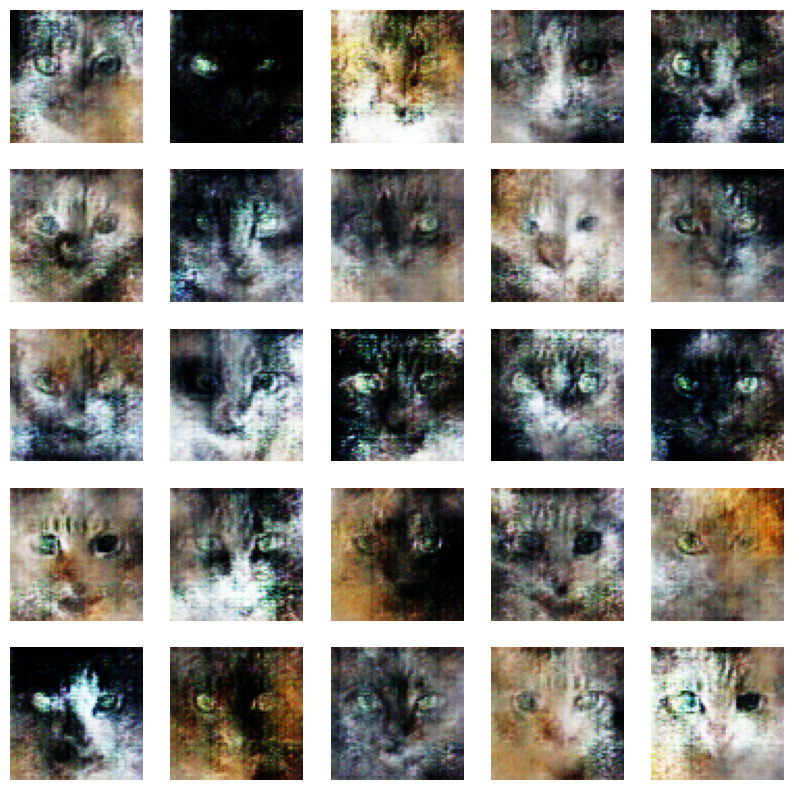

100%|██████████| 492/492 [00:08<00:00, 61.13it/s]


Epoch  2 / 20 : Discriminator Loss:  0.9783901284501805 Generator:  3.256356559936109


100%|██████████| 492/492 [00:07<00:00, 61.75it/s]


Epoch  3 / 20 : Discriminator Loss:  0.9978403689738534 Generator:  3.040721997457145


100%|██████████| 492/492 [00:08<00:00, 61.09it/s]


Epoch  4 / 20 : Discriminator Loss:  0.9946792433114071 Generator:  2.976286512776846


100%|██████████| 492/492 [00:08<00:00, 61.28it/s]


Epoch  5 / 20 : Discriminator Loss:  0.9727303423169182 Generator:  3.0277311194597223


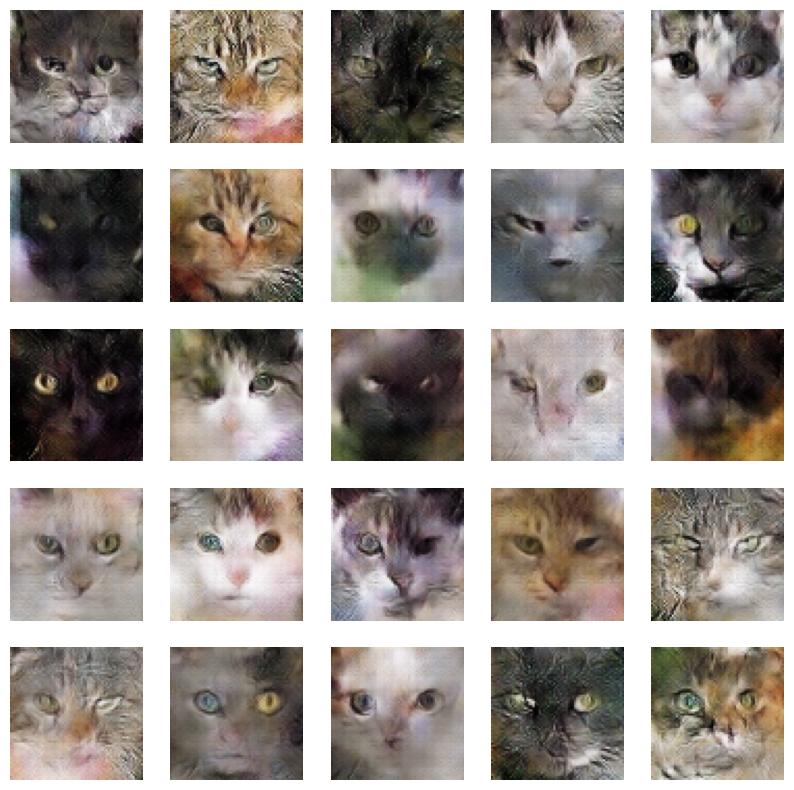

100%|██████████| 492/492 [00:08<00:00, 60.34it/s]


Epoch  6 / 20 : Discriminator Loss:  0.9563175167681442 Generator:  3.0912957435075024


100%|██████████| 492/492 [00:08<00:00, 60.05it/s]


Epoch  7 / 20 : Discriminator Loss:  0.9360334009351804 Generator:  3.1409015499842847


100%|██████████| 492/492 [00:08<00:00, 60.17it/s]


Epoch  8 / 20 : Discriminator Loss:  0.9142070064790607 Generator:  3.177974894529254


100%|██████████| 492/492 [00:08<00:00, 59.55it/s]


Epoch  9 / 20 : Discriminator Loss:  0.9015067763889062 Generator:  3.233415730982386


100%|██████████| 492/492 [00:08<00:00, 59.99it/s]


Epoch  10 / 20 : Discriminator Loss:  0.8807637332173867 Generator:  3.268917515878452


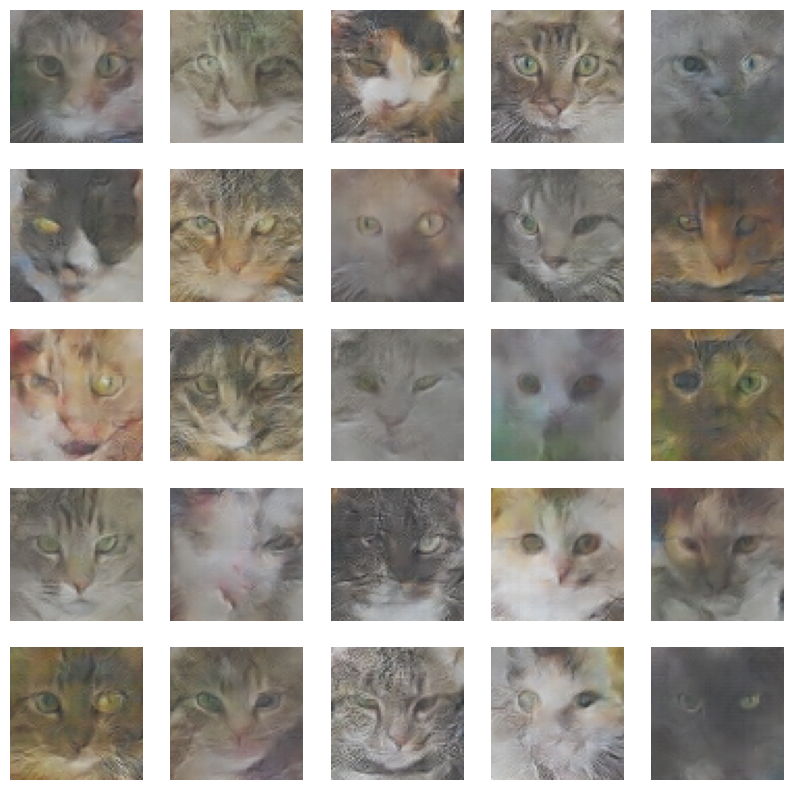

100%|██████████| 492/492 [00:08<00:00, 59.45it/s]


Epoch  11 / 20 : Discriminator Loss:  0.8658365032360982 Generator:  3.3068017732208843


100%|██████████| 492/492 [00:08<00:00, 59.28it/s]


Epoch  12 / 20 : Discriminator Loss:  0.85354466147741 Generator:  3.324166718046345


100%|██████████| 492/492 [00:08<00:00, 59.79it/s]


Epoch  13 / 20 : Discriminator Loss:  0.8451320613158391 Generator:  3.3380958835784815


100%|██████████| 492/492 [00:08<00:00, 58.88it/s]


Epoch  14 / 20 : Discriminator Loss:  0.8322904344981279 Generator:  3.358044209089628


100%|██████████| 492/492 [00:08<00:00, 59.35it/s]


Epoch  15 / 20 : Discriminator Loss:  0.8260960876941681 Generator:  3.3886954066744908


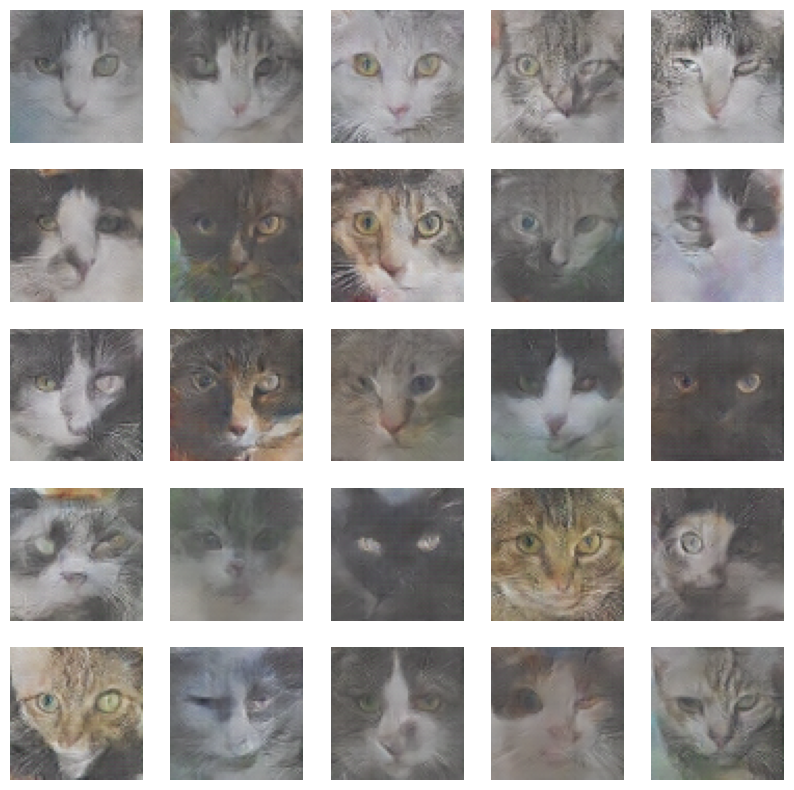

100%|██████████| 492/492 [00:08<00:00, 58.31it/s]


Epoch  16 / 20 : Discriminator Loss:  0.8184684956582581 Generator:  3.392633030754211


100%|██████████| 492/492 [00:09<00:00, 51.57it/s]


Epoch  17 / 20 : Discriminator Loss:  0.8094649793467044 Generator:  3.410822105524052


100%|██████████| 492/492 [00:08<00:00, 59.20it/s]


Epoch  18 / 20 : Discriminator Loss:  0.798888961002971 Generator:  3.434960371225756


100%|██████████| 492/492 [00:08<00:00, 58.61it/s]


Epoch  19 / 20 : Discriminator Loss:  0.7887414020107988 Generator:  3.463658875598866


100%|██████████| 492/492 [00:08<00:00, 58.70it/s]


Epoch  20 / 20 : Discriminator Loss:  0.7785873075916878 Generator:  3.4875965679087106


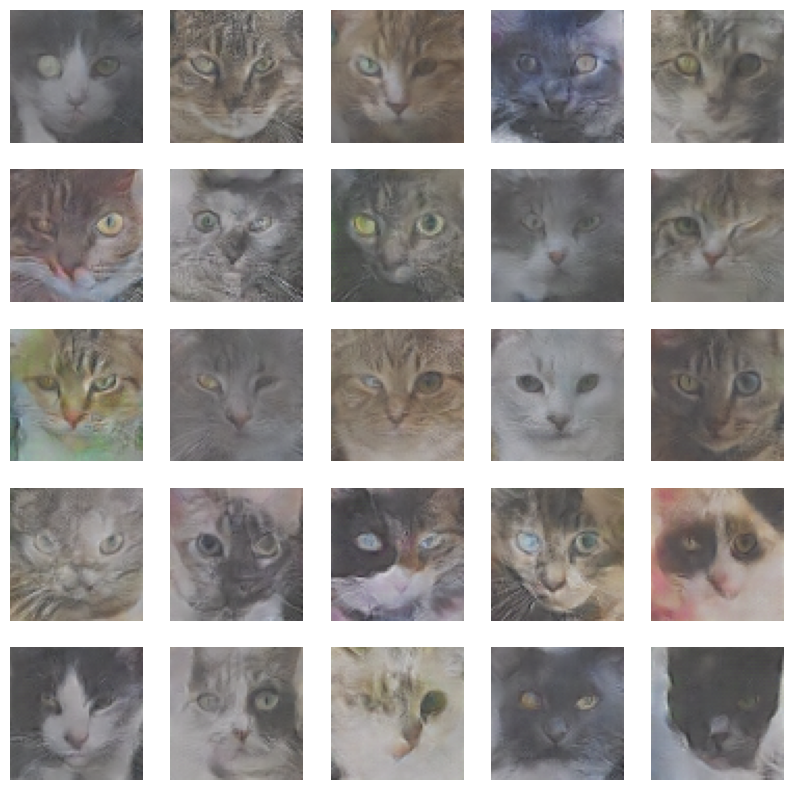

In [ ]:
gen, disc = run()